In [11]:
import json, os
import glob, pickle

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, modify_and_add_noise_to_model
from gnn import ExpValCircuitGraphModel, ExpValCircuitGraphModel_2, ExpValCircuitGraphModel_3
from mlp import MLP1, MLP2, MLP3, encode_data
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from noise_utils import AddNoise

plt.style.use({'figure.facecolor':'white'})
D = {'output': 'mpl', 'fold': -1}

In [12]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [13]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_coherent, noise_model = AddNoise(backend=backend).add_coherent_noise(seed=0, theta=np.pi * 0.04, uniform=False, add_depolarization=True)

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_coherent = {'shots': 10000, 'backend': backend_noisy_coherent, 'name': 'noisy_coherent'}

num_qubit = 4

random seed fixed to 0
thetas [0.06896594 0.08987335 0.07574548 0.06847204 0.05323803 0.08116545
 0.05498883 0.1120635 ]


In [14]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [67]:
model_path_1 = './model/ising_init_from_qasm/gnn1.pth'
model_path_2 = './model/ising_init_from_qasm/mlp1_smaller.pth'
model_path_3 = './model/ising_init_from_qasm/ols_full.pk'
model_path_4 = './model/ising_init_from_qasm/ols.pk'
model_path_5 = './model/ising_init_from_qasm/rfr_list.pk'

In [68]:
models = []

model_1 = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
model_1.load_state_dict(torch.load(model_path_1), strict=True)
model_1.eval()
models.append((model_1, 'gnn'))

model_2 = MLP1(
    input_size=58,
    output_size=4,
    hidden_size=64
)
model_2.load_state_dict(torch.load(model_path_2), strict=True)
model_2.eval()
models.append((model_2, 'mlp'))

with open(model_path_3, 'rb') as f:
    model_3 = pickle.load(f)
models.append((model_3, 'ols_full'))

with open(model_path_4, 'rb') as f:
    model_4 = pickle.load(f)
models.append((model_4, 'ols'))

with open(model_path_5, 'rb') as f:
    model_5 = pickle.load(f)
models.append((model_5, 'rfr_list'))

models.append((None, 'zne'))

In [69]:
from qiskit import *
from typing import TypedDict

import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from qiskit.result import sampled_expectation_value, Counts
from typing import Union, List, Dict

class CountsProcess:

    @classmethod
    def pauli_exp_val_all1Q_for_counts(cls, counts:Union[List[Counts], Counts], nolabels=False):
        """ Pauli expectaitoin value for all isngle qubit Z observables across all counts.
            - Simplest version
            - Not very efficient
        Returns:
            - <Z> for qubit Q0...Qn-1 with ordering qubit index is array index.
            - Pauli labels returened are in rightmost is Q0 (qiskit convention)
              To put ot physics notation when in df columns:
                    df.columns = list(map(lambda x: x[::-1],df.columns))
            """
        if isinstance(counts, Counts):
            nq = counts.creg_sizes[0][1]
            expects = [] if nolabels else {}
            for n in range(nq):
                # In the string representation qubit-0 corresponds to the right-most Pauli character
                pauli = SparsePauliOp.from_sparse_list([("Z", [n], 1)], nq)
                expect = sampled_expectation_value(counts, pauli)
                if nolabels:
                    expects += [expect]
                else:
                    expects[pauli.paulis.to_labels()[0]] = expect
            return expects
        elif isinstance(counts, list):
            expects = []
            for count in counts:
                expect = cls.pauli_exp_val_all1Q_for_counts(count)
                expects += [expect]
            return expects

    @classmethod
    def pauli_exp_val_all2Q_for_counts(cls, counts:Union[List[Counts], Counts], nolabels=False):
        """ Pauli expectaitoin value for all isngle qubit Z observables across all counts.
            - Simplest version
            - Not very efficient
        Returns:
            - <Z> for qubit Q0...Qn-1 with ordering qubit index is array index.
            - Pauli labels returened are in rightmost is Q0 (qiskit convention)
              To put ot physics notation when in df columns:
                    df.columns = list(map(lambda x: x[::-1],df.columns))
            """
        if isinstance(counts, Counts):
            nq = counts.creg_sizes[0][1]
            expects = [] if nolabels else {}
            for n in range(nq):
                for m in range(n+1, nq):
                    # In the string representation qubit-0 corresponds to the right-most Pauli character
                    pauli = SparsePauliOp.from_sparse_list([("ZZ", [n,m], 1)], nq)
                    expect = sampled_expectation_value(counts, pauli)
                    if nolabels:
                        expects += [expect]
                    else:
                        expects[pauli.paulis.to_labels()[0]] = expect
            return expects
        elif isinstance(counts, list):
            expects = []
            for count in counts:
                expect = cls.pauli_exp_val_all2Q_for_counts(count)
                expects += [expect]
            return expects


class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper(self):
            self['h'] = 1
            self['J'] = 0.5236
            self['dt'] = 1/4


    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, sweep_steps = None, measure_bases = None):
        sweep_steps = sweep_steps or [16]
        measure_bases = measure_bases or ['Z']

        circs = []
        run_params = []
        for basis in measure_bases:
            for depth in range(*sweep_steps):
                ops['measure_basis'] = basis
                ops['depth'] = depth
                qc = cls.make_quantum_circuit(ops)
                qc.metadata = {}
                qc.metadata['measure_basis'] = basis
                qc.metadata['depth'] = depth
                run_params += [qc.metadata.copy()]
                circs += [qc]
        return circs, run_params

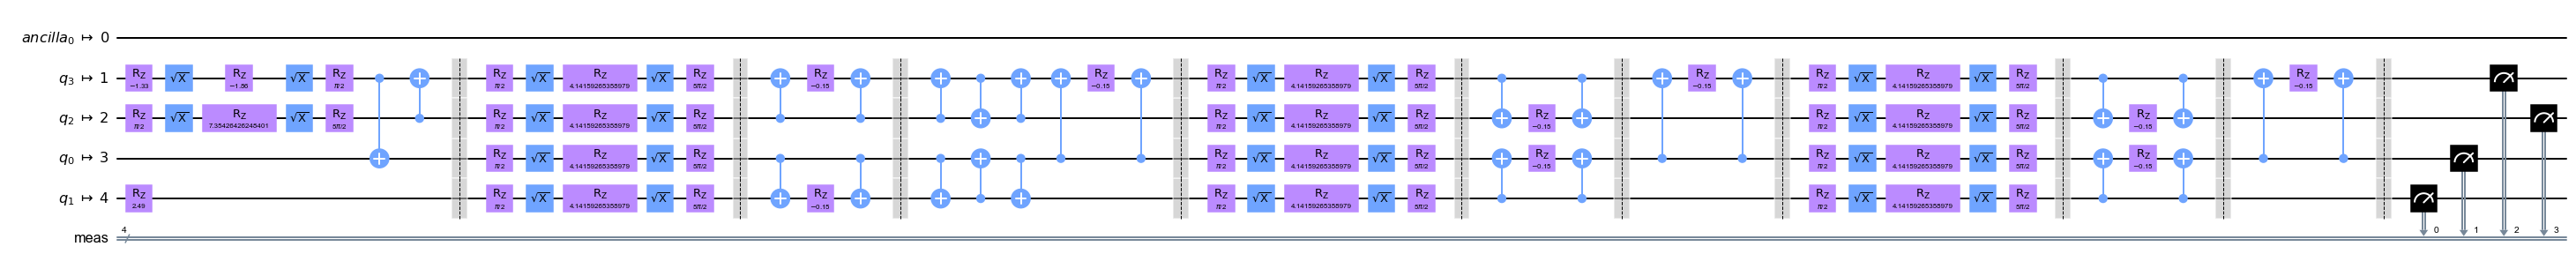

In [79]:
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import RYGate, RXGate, RZGate, CXGate
from qiskit import QuantumRegister

def generate_random_initial_state():
    qc = QuantumCircuit(4)
    random_state = random_statevector(2**4).data
    qc.initialize(random_state, list(range(4)))
    return qc

def generate_random_initial_num_gate(num_gates=2):
    qr = QuantumRegister(4, 'q')
    qc = QuantumCircuit(qr)

    for _ in range(num_gates):
        gate_type = np.random.choice(['rx', 'rz', 'cnot'])
        qubit_indices = np.random.choice(range(4), size=2, replace=False)

        if gate_type == 'ry':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RYGate(theta), [qr[qubit_indices[0]]])
        elif gate_type == 'rx':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RXGate(theta), [qr[qubit_indices[0]]])
        elif gate_type == 'rz':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RZGate(theta), [qr[qubit_indices[0]]])
        elif gate_type == 'id':
            pass
        elif gate_type == 'cnot':
            theta = 2 * np.pi * np.random.rand()
            qc.append(RXGate(theta), [qr[qubit_indices[0]]])
            qc.append(CXGate(), [qr[qubit_indices[0]], qr[qubit_indices[1]]])

    return qc

def construct_ising_circuit_random_init(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_4q_paper()
    ops.update({'J': J})
    qc_init = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\nrz(0.0007186381718527407) q[1];\nrz(2.4917901988569855) q[1];\nrz(3.3854853863523835) q[3];\nrx(1.2846113715328817) q[3];\ncx q[3],q[0];\nrx(4.212671608894216) q[2];\ncx q[2],q[3];\n')
    # qc_init = QuantumCircuit(4)
    # # qc_init.initialize(random_statevector(2**4).data, qc_init.qubits)
    # qc_init.x(1)
    # qc_init.x(2)
    qc_init.barrier()
    max_step = 30
    qc_list = []
    for i in range(max_step):
        qc_list.append(qc_init.compose(cls.make_circs_sweep(ops, sweep_steps=[max_step], measure_bases=['Z'])[0][i], list(range(4))))
    return qc_list

np.random.seed(5)
J = 0.15
basis = 'Z'
random_ising = construct_ising_circuit_random_init(J, basis, 2)
######################## NEED TO CHANGE THE BACKEND HERE for OLS Full to work #############################
qc_list = transpile(random_ising, backend=backend_noisy, optimization_level=3)
qc_list[3].draw('mpl', fold=-1)
###########################################################################################################

In [71]:
# np.random.seed(1)
# qc_init = generate_random_initial_num_gate(5)
# qc_init.qasm()

In [72]:
# cls = IsingModel
# ops = cls.Options()
# ops.config_4q_paper()
# # ops.config_10q_paper()
# qc_list, run_params = cls.make_circs_sweep(ops, sweep_steps=[15], measure_bases=['Z'])
# qc_list[1].draw('mpl', fold=-1)

In [80]:
from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *
from qiskit.primitives import BackendEstimator

def get_zne_expval(circ,
                   obs: str,
                   extrapolator,
                   backend,
                   noise_factors = [1, 3, 5, 7],
                   amplifier=LocalFoldingAmplifier(gates_to_fold=2),
                   shots:int=10000,
                   ) -> float:
    observable = SparsePauliOp(obs)

    ZNEEstimator = zne(BackendEstimator)
    estimator = ZNEEstimator(backend=backend)

    zne_strategy = ZNEStrategy(
        noise_factors=noise_factors,
        noise_amplifier=amplifier,
        extrapolator=extrapolator
    )

    job = estimator.run(circ, observable, shots=shots, zne_strategy=zne_strategy)
    values = job.result().values
    # we use a different convention where +1 is the eigenvalue for |1> state, because cal_z_exp assumes 0 is -Z and 1 is +Z
    values *= -1

    return values.tolist()

def get_measurement_qubits(qc, num_qubit):
        measurement_qubits = []
        for measurement in range(num_qubit-1, -1, -1):
            measurement_qubits.append(qc.data[-1-measurement][1][0].index)
        return measurement_qubits

def zne_mitigating_single_z(circ, backend, extrapolator):
    mapping = get_measurement_qubits(circ, 4)
    mapping = mapping[::-1]
    for i in range(5):
        if i not in mapping:
            mapping = mapping + [i]

    mitigated = []
    # ob_list has single Z measurement on the first qubit in the last position, i.e., 'ZIIII' is measuring the top qubit (Non-endian notation)
    ob_list = np.array(['ZIIII', 'IZIII', 'IIZII', 'IIIZI', 'IIIIZ'][::-1])
    ob_list = ob_list[np.array(mapping)].tolist()   # ancilla always mapped to the last position of the ob_list
    for obs in ob_list[:-1]:
        mitigated += get_zne_expval(circ, obs, extrapolator, backend)
    return mitigated

In [82]:
from tqdm.notebook import tqdm

fix_random_seed(0)

num_traj = 1

def run_ising_steps(be, r_c_n):
    exp_Z_all_ideal = []
    exp_Z_all_noisy = []
    exp_Z_all_mitigated_dict = defaultdict(list)

    for _ in range(num_traj):

        transpiled_qc_list = transpile(qc_list, be, optimization_level=3)
        job_ideal = execute(qc_list, **run_config_ideal)
        job_noisy = execute(transpiled_qc_list, **r_c_n)

        exp_Z_ideal = []
        exp_Z_noisy = []
        exp_Z_mitigated_dict = defaultdict(list)

        for i in tqdm(range(len(qc_list))):
            counts_ideal = job_ideal.result().get_counts()[i]
            counts_noisy = job_noisy.result().get_counts()[i]

            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)

            exp_Z_ideal.append(list(ideal_exp_val))  # Single-Z expectation value of each qubit
            exp_Z_noisy.append(list(noisy_exp_val))  # Single-Z expectation value of each qubit

            graph_data = circuit_to_graph_data_json(
                circuit=transpiled_qc_list[i],
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )
            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=ideal_exp_val.tolist(),
                noisy_exp_values=[noisy_exp_val.tolist()],
                circuit_depth=transpiled_qc_list[i].depth()
            ).to_pyg_data()

            X, _ = encode_data([transpiled_qc_list[i]], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

            for j, (model, mtype) in enumerate(models):
                if mtype == 'mlp':
                    mitigated_exp_val = model(X).tolist()[0]
                elif mtype == 'gnn':
                    mitigated_exp_val = model(entry.noisy_0,
                                            entry.observable,
                                            entry.circuit_depth,
                                            entry.x,
                                            entry.edge_index,
                                            entry.batch).tolist()[0]
                elif mtype in ['ols_full', 'rfr_full']:
                    mitigated_exp_val = model.predict(X).tolist()[0]
                elif mtype in ['ols', 'rfr']:
                    mitigated_exp_val = model.predict(X[:, -4:]).tolist()[0]
                elif mtype in ['rfr_list']:
                    mitigated_exp_val = []
                    for q, m in enumerate(model):
                        mitigated_exp_val.append(m.predict(X))
                    mitigated_exp_val = np.array(mitigated_exp_val).transpose()
                elif mtype in ['zne']:
                    mitigated_exp_val = zne_mitigating_single_z(transpiled_qc_list[i], be, PolynomialExtrapolator(degree=2))
                else:
                    raise NotImplementedError

                exp_Z_mitigated_dict[j].append(mitigated_exp_val)

        exp_Z_all_ideal.append(exp_Z_ideal)
        exp_Z_all_noisy.append(exp_Z_noisy)
        for k, exp_Z_mitigated in exp_Z_mitigated_dict.items():
            exp_Z_all_mitigated_dict[k].append(exp_Z_mitigated)

    return exp_Z_all_ideal, exp_Z_all_noisy, exp_Z_all_mitigated_dict

######################## Need to change ##############################
exp_Z_all_ideal, exp_Z_all_noisy, exp_Z_all_mitigated_dict = run_ising_steps(backend_noisy, run_config_noisy)
######################## Need to change ##############################

random seed fixed to 0


  0%|          | 0/30 [00:00<?, ?it/s]

In [83]:
exp_Z_all_ideal = np.array(exp_Z_all_ideal).squeeze()
exp_Z_all_noisy = np.array(exp_Z_all_noisy).squeeze()
for key, val in exp_Z_all_mitigated_dict.items():
    exp_Z_all_mitigated_dict[key] = np.array(val).squeeze()

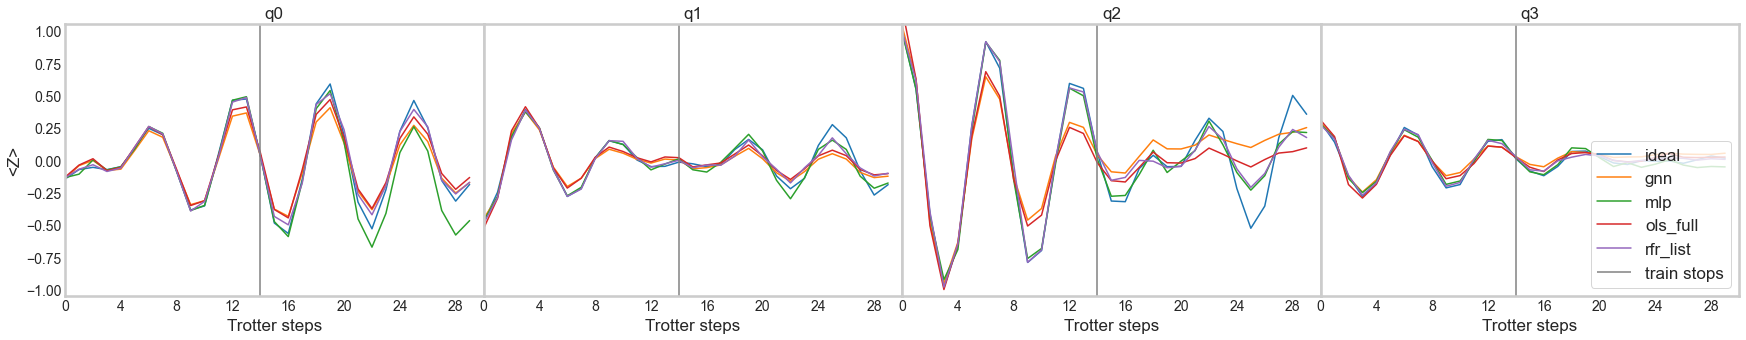

In [84]:
import matplotlib as mpl
ms, fs, lw, elw, cs = 9, 17, 2.5, 2, 0
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', weight='normal')

fig = plt.figure(figsize=(30, 5))
ax = [fig.add_subplot(1,4,i+1) for i in range(4)]
plt.style.use({'figure.facecolor':'white'})

for q in range(4):
    ax[q].plot(-exp_Z_all_ideal[:, q], label='ideal')
    # ax[q].plot(-exp_Z_all_noisy[:, q], label='noisy')
    for key, val in exp_Z_all_mitigated_dict.items():
        if models[key][1] in [
            'gnn',
            'mlp',
            'ols_full',
            'rfr_list',
            # 'zne'
        ]:
            ax[q].plot(-val[:, q], label=f'{models[key][1]}')
    ax[q].vlines(x=14, ymin=-2, ymax=2, color='gray', label = 'train stops')
    ax[q].grid(False)

for a in ax[1:]:
    a.set_yticklabels([])
for a in ax:
    a.tick_params(direction="in")
    a.set_ylim([-1.05, 1.05])
    a.set_xlim([0, 30])
    a.set_xlabel('Trotter steps', fontsize=fs)
    a.set_xticks(np.arange(0, 29, 4))
for a in ax:
    for axis in ['top','bottom','left','right']:
        a.spines[axis].set_linewidth(2.6)

for q in range(4):
    ax[q].set_title(f'q{q}', fontsize=fs)
plt.subplots_adjust(wspace=0, hspace=0)
plt.legend(loc='lower right', fontsize=fs)
ax[0].set_ylabel(f'<Z>', fontsize=fs)
plt.show()

In [85]:
# to_dump = {
#     'exp_Z_all_ideal': exp_Z_all_ideal,
#     'exp_Z_all_noisy': exp_Z_all_noisy,
#     'exp_Z_all_mitigated_dict': exp_Z_all_mitigated_dict,
#     'models': [model[1] for model in models],
# }
# with open('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/incoherent_single_ising.pk', 'wb') as file:
#     pickle.dump(to_dump, file)